# Assignment 3

Imports

In [232]:
import numpy as np
import scipy as sp
from scipy.optimize import dual_annealing, curve_fit
from scipy.integrate import solve_ivp, odeint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from numba import jit, njit, prange
import math
import os
import random

In [233]:
SEED = 33
np.random.seed(SEED)

os.makedirs('media', exist_ok=True)

if not os.path.isfile('predator-prey-data.csv'):
    raise FileNotFoundError("File 'predator-prey-data.csv' not found.")

data = pd.read_csv('predator-prey-data.csv').drop(columns=['Unnamed: 0'])
t, x, y = data['t'].to_numpy(), data['x'].to_numpy(), data['y'].to_numpy()

In [234]:
LOW_PARAM_BOUND = 0
UP_PARAM_BOUND = 2
MAX_STEPS_HILLCLIMING = 500
MAX_ITER_SA = 100

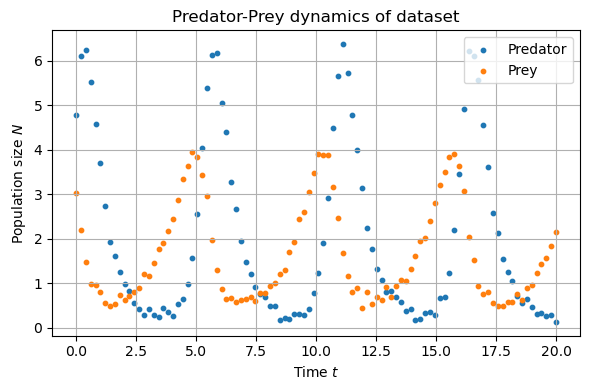

In [235]:
plt.figure(figsize=(6, 4), layout='tight')
plt.scatter(t, x, s=10, label='Predator')
plt.scatter(t, y, s=10, label='Prey')
plt.title('Predator-Prey dynamics of dataset')
plt.xlabel('Time $t$')
plt.ylabel('Population size $N$')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('media/dataset.png')
plt.show()

In [236]:
def solve_lv(params, init_conditions, t):
    alpha, beta, gamma, delta = params

    def lv_odes(y, t):
        x, z = y
        dxdt = alpha*x - beta*x*z
        dzdt = delta*x*z - gamma*z
        return np.array([dxdt, dzdt])

    solution = odeint(lv_odes, init_conditions, t)
    return solution

In [237]:
def get_initial_random_guess(lower_bound=LOW_PARAM_BOUND, upper_bound=UP_PARAM_BOUND):
    alpha = random.uniform(lower_bound, upper_bound)
    beta = random.uniform(lower_bound, upper_bound)
    gamma = random.uniform(lower_bound, upper_bound)
    delta = random.uniform(lower_bound, upper_bound)
    return [alpha, beta, gamma, delta]

In [238]:
def get_neighbors(solution, step_size=0.1):
    """Calculate the neighbors of a solution, given a step size."""
    neighbors = []
    for i in range(len(solution)):
        # Add step_size to the parameter if it doesn't exceed PARAM_MAX
        if solution[i] + step_size <= UP_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] + step_size for j in range(len(solution))])
        # Subtract step_size from the parameter if it doesn't become less than PARAM_MIN
        if solution[i] - step_size >= LOW_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] - step_size for j in range(len(solution))])
    return neighbors


def choose_next_step(loss_function, current_step):
    neighbors = get_neighbors(current_step)
    return min(neighbors, key=loss_function)


def hill_climbing(loss_function, initial_step, max_steps):
    """Perform the Hill Climbing optimization algorithm."""
    current_step = initial_step
    history = [current_step]

    for _ in range(max_steps):
        try:
            next_step = choose_next_step(loss_function, current_step)
            if loss_function(next_step) >= loss_function(current_step):
                break
            history.append(next_step)
            current_step = next_step
        except Exception as e:
            print(f"An error occurred during the hill climbing: {str(e)}")
            break

    return current_step, history

def classic_annealing(*args, **kwargs):
    return dual_annealing(*args, **kwargs, no_local_search=True)

In [239]:
def mse_objective(params):
    initial_conditions = [y[0], x[0]]
    sim_data = solve_lv(params, initial_conditions, t)
    mse = np.mean((sim_data - data[['y', 'x']].values) ** 2)
    return mse

def mae_objective(params):
    initial_conditions = [y[0], x[0]]
    sim_data = solve_lv(params, initial_conditions, t)
    mae = np.mean(np.abs(sim_data - data[['y', 'x']].values))
    return mae

In [240]:
bounds = [(LOW_PARAM_BOUND, UP_PARAM_BOUND)] * 4
initial_guess = get_initial_random_guess()
hc_optimizers = [hill_climbing]
sa_optimizers = [classic_annealing, dual_annealing]
optimizers = hc_optimizers + sa_optimizers
objectives = [mse_objective, mae_objective]
est_params = {opt.__name__: {obj.__name__: [] for obj in objectives} for opt in optimizers}


for obj in objectives:
    for opt in hc_optimizers:
        params, _ = hill_climbing(
            obj, initial_guess, max_steps=MAX_STEPS_HILLCLIMING)
        est_params[opt.__name__][obj.__name__] = params
        print(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")
    for opt in sa_optimizers:
        params = opt(obj, bounds=bounds, maxiter=MAX_ITER_SA).x
        est_params[opt.__name__][obj.__name__] = params
        print(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")

Params of hill_climbing with mse_objective: ['1.546', '1.243', '1.624', '1.300'] - Loss: 7.52e-01
Params of classic_annealing with mse_objective: ['1.359', '0.713', '1.511', '1.290'] - Loss: 2.64e-01


/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Params of dual_annealing with mse_objective: ['0.860', '0.440', '2.000', '1.158'] - Loss: 9.63e-03
Params of hill_climbing with mae_objective: ['1.546', '1.243', '1.624', '1.300'] - Loss: 7.46e-01
Params of classic_annealing with mae_objective: ['1.379', '0.586', '1.183', '0.682'] - Loss: 3.44e-01


/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/scipy/integrate/_o

Params of dual_annealing with mae_objective: ['0.876', '0.449', '1.965', '1.142'] - Loss: 7.79e-02


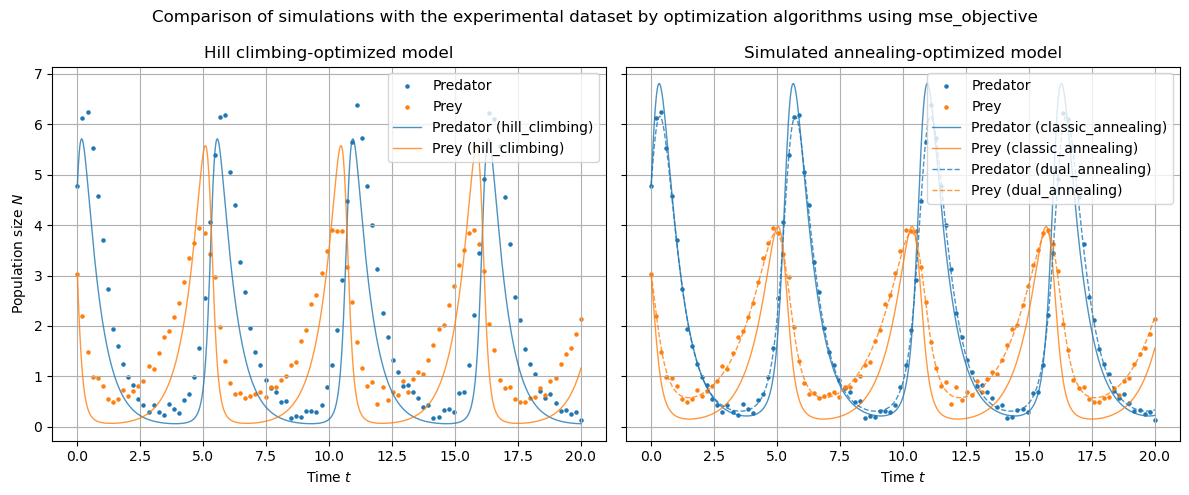

In [241]:
def plot_comparison_optimizers(hc_optimizers, sa_optimizers, objective=mse_objective, linestyles=['-', '--', ':'], colors=['tab:blue', 'tab:orange']):
    t_detail = np.linspace(0, 20, 1000)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='tight', sharey=True)
    fig.suptitle(f'Comparison of simulations with the experimental dataset by optimization algorithms using {objective.__name__}')
    axs[0].scatter(t, x, s=5, label='Predator', color=colors[0])
    axs[0].scatter(t, y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(hc_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [y[0], x[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[0].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[0].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[0].set_title('Hill climbing-optimized model')
    axs[0].set_xlabel('Time $t$')
    axs[0].set_ylabel('Population size $N$')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)
    axs[1].scatter(t, x, s=5, label='Predator', color=colors[0])
    axs[1].scatter(t, y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(sa_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [y[0], x[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[1].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[1].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[1].set_title('Simulated annealing-optimized model')
    axs[1].set_xlabel('Time $t$')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)
    plt.savefig('media/comparison_optimizers.png')
    plt.show()

plot_comparison_optimizers(hc_optimizers, sa_optimizers)

Removing samples functionality

100%|██████████| 200/200 [02:25<00:00,  1.38it/s]


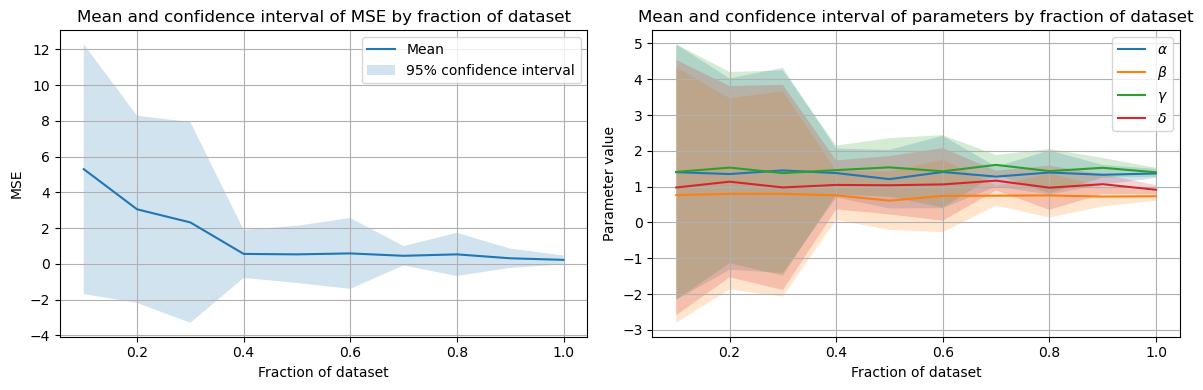

In [261]:
def gen_sample_dataset(data, frac):
    data = data.copy()
    return data.sample(frac=frac).sort_values(by='t').reset_index(drop=True)

def batch_comparison_by_frac(fracs, n_samples=10, optimizer=classic_annealing, objective=mse_objective, initial_conditions=[y[0], x[0]], **kwargs):
    results = []
    with tqdm(total=len(fracs)*n_samples) as pbar:
        for frac in fracs:
            mse = []
            params_list = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(objective, **kwargs).x
                params_list.append(params)
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                mse.append(mean_squared_error(sim_data, sample_data[['y', 'x']].values))
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int, np.mean(params_list, axis=0)])
    return pd.DataFrame(results, columns=['frac', 'mean_mse', 'std_mse', 'conf_int', 'mean_params'])

fracs = np.linspace(0.1, 1.0, 10)
experiment_df = batch_comparison_by_frac(fracs=fracs, n_samples=20, bounds=bounds, maxiter=MAX_ITER_SA)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout='tight')

axs[0].plot(experiment_df['frac'], experiment_df['mean_mse'], label='Mean')
axs[0].fill_between(experiment_df['frac'], experiment_df['conf_int'].apply(lambda x: x[0]), experiment_df['conf_int'].apply(lambda x: x[1]), alpha=0.2, label='95% confidence interval')
axs[0].set_title('Mean and confidence interval of MSE by fraction of dataset')
axs[0].set_xlabel('Fraction of dataset')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Plot the mean parameters by fraction of dataset and their confidence interval
for i, param in enumerate(['alpha', 'beta', 'gamma', 'delta']):
    axs[1].plot(experiment_df['frac'], experiment_df['mean_params'].apply(lambda x: x[i]), label=f'$\\{param}$')
    axs[1].fill_between(experiment_df['frac'], experiment_df['mean_params'].apply(lambda x: x[i]) - experiment_df['std_mse'], experiment_df['mean_params'].apply(lambda x: x[i]) + experiment_df['std_mse'], alpha=0.2)
axs[1].set_title('Mean and confidence interval of parameters by fraction of dataset')
axs[1].set_xlabel('Fraction of dataset')
axs[1].set_ylabel('Parameter value')
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.savefig('media/frac_conf_mse_params.png')
plt.show()

## Experiments and plots

#### How many data-points from each time-series you could remove until you are not able to reverse-engineer the parameters any more?

First, try to ﬁnd the importance of each time-series on reverse-engineering process by ﬁxing one time-series and removing data-points from the other one. In this way, you will ﬁnd the critical number of data-points for each time-series.

Then, if you combine two reduced time-series, could you still infer the parameters?

Does removing every data-point have the same effect on reverse-engineering process? In other words, what are the points that you could remove safely without affecting the inferance procedure? and what are those with critical effects on the process?

#### \<Extra question\>